In [ ]:

#mount drive
from google.colab import drive
drive.mount('/content/MyDrive')
import seaborn as sns
sns.set_theme("paper")



Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [ ]:
# @title Initialize Config

import torch
import numpy
class Config:
    def __init__(self, **kwargs):
        self.channels_imu_acc = kwargs.get('channels_imu_acc', [])
        self.channels_imu_gyr = kwargs.get('channels_imu_gyr', [])
        self.channels_joints = kwargs.get('channels_joints', [])
        self.channels_emg = kwargs.get('channels_emg', [])
        self.seed = kwargs.get('seed', 42)
        self.data_folder_name = kwargs.get('data_folder_name', 'default_data_folder_name')
        self.dataset_root = kwargs.get('dataset_root', 'default_dataset_root')
        self.imu_transforms = kwargs.get('imu_transforms', [])
        self.joint_transforms = kwargs.get('joint_transforms', [])
        self.emg_transforms = kwargs.get('emg_transforms', [])
        self.input_format = kwargs.get('input_format', 'csv')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config(
    data_folder_name='/content/MyDrive/MyDrive/sd_datacollection_v3/all_subjects_data.h5',
    dataset_root='/content/datasets',
    input_format="csv",
    channels_imu_acc=['ACCX1', 'ACCY1', 'ACCZ1','ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_gyr=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_joints=['elbow_flex_r', 'arm_flex_r', 'arm_add_r'],
    channels_emg=['IM EMG4', 'IM EMG5', 'IM EMG6'],
)

#set seeds
torch.manual_seed(config.seed)
numpy.random.seed(config.seed)


In [ ]:
# @title Datasharder
class DataSharder:
    def __init__(self, config, split):
        self.config = config
        self.h5_file_path = config.data_folder_name  # Path to the HDF5 file
        self.split = split

    def load_data(self, subjects, window_length, window_overlap, dataset_name):
        print(f"Processing subjects: {subjects} with window length: {window_length}, overlap: {window_overlap}")

        self.window_length = window_length
        self.window_overlap = window_overlap

        # Process the data from the HDF5 file
        self._process_and_save_patients_h5(subjects, dataset_name)

    def _process_and_save_patients_h5(self, subjects, dataset_name):
        # Open the HDF5 file
        with h5py.File(self.h5_file_path, 'r') as h5_file:
            dataset_folder = os.path.join(self.config.dataset_root, dataset_name, self.split).replace("subject", "").replace("__", "_")
            print("Dataset folder:", dataset_folder)

            if os.path.exists(dataset_folder):
                print("Dataset Exists, Skipping...")
                return

            os.makedirs(dataset_folder, exist_ok=True)
            print("Dataset folder created: ", dataset_folder)

            for subject_id in tqdm(subjects, desc="Processing subjects"):
                subject_key = subject_id
                if subject_key not in h5_file:
                    print(f"Subject {subject_key} not found in the HDF5 file. Skipping.")
                    continue

                subject_data = h5_file[subject_key]
                session_keys = list(subject_data.keys())  # Sessions for this subject

                for session_id in session_keys:
                    session_data_group = subject_data[session_id]

                    for sessions_speed in session_data_group.keys():
                        session_data = session_data_group[sessions_speed]

                        # Extract IMU, EMG, and Joint data as numpy arrays
                        imu_data, imu_columns = self._extract_channel_data(session_data, self.config.channels_imu_acc + self.config.channels_imu_gyr)
                        emg_data, emg_columns = self._extract_channel_data(session_data, self.config.channels_emg)
                        joint_data, joint_columns = self._extract_channel_data(session_data, self.config.channels_joints)

                        # Shard the data into windows and save each window
                        self._save_windowed_data(imu_data, emg_data, joint_data, subject_key, session_id,sessions_speed, dataset_folder, imu_columns, emg_columns, joint_columns)

    def _save_windowed_data(self, imu_data, emg_data, joint_data, subject_key, session_id, session_speed, dataset_folder, imu_columns, emg_columns, joint_columns):
        window_size = self.window_length
        overlap = self.window_overlap
        step_size = window_size - overlap

        # Path to the CSV log file
        csv_file_path = os.path.join(dataset_folder, '..', f"{self.split}_info.csv")

        # Ensure the folder exists
        os.makedirs(dataset_folder, exist_ok=True)

        # Prepare CSV log headers (ensure the columns are 'file_name' and 'file_path')
        csv_headers = ['file_name', 'file_path']

        # Create or append to the CSV log file
        file_exists = os.path.isfile(csv_file_path)
        with open(csv_file_path, mode='a', newline='') as csv_file:
            writer = csv.writer(csv_file)

            # Write the headers only if the file is new
            if not file_exists:
                writer.writerow(csv_headers)

            # Determine the total data length based on the minimum length across the data sources
            total_data_length = min(imu_data.shape[1], emg_data.shape[1], joint_data.shape[1])

            # Adjust the starting point for windows based on total data length
            start = 2000 if total_data_length > 4000 else 0

            # Ensure that each window across imu_data, emg_data, and joint_data has the same shape before concatenation
            for i in range(start, total_data_length - window_size + 1, step_size):
                imu_window = imu_data[:, i:i + window_size]
                emg_window = emg_data[:, i:i + window_size]
                joint_window = joint_data[:, i:i + window_size]

                # Check if the window sizes are valid
                if imu_window.shape[1] == window_size and emg_window.shape[1] == window_size and joint_window.shape[1] == window_size:
                    # Convert windowed data to pandas DataFrame



                    imu_df = pd.DataFrame(imu_window.T, columns=imu_columns)
                    emg_df = pd.DataFrame(emg_window.T, columns=emg_columns)
                    joint_df = pd.DataFrame(joint_window.T, columns=joint_columns)



                    # Concatenate the data along the column axis
                    combined_df = pd.concat([imu_df, emg_df, joint_df], axis=1)

                    # Save the combined windowed data as a CSV file
                    file_name = f"{subject_key}_{session_id}_{session_speed}_win_{i}_ws{window_size}_ol{overlap}.csv"
                    file_path = os.path.join(dataset_folder, file_name)
                    combined_df.to_csv(file_path, index=False)

                    # Log the file name and path in the CSV (in the correct columns)
                    writer.writerow([file_name, file_path])
                else:
                    print(f"Skipping window {i} due to mismatched window sizes.")

    def _extract_channel_data(self, session_data, channels):
        """
        Extracts data for the given channels from the dataset (whether it's a compound dataset or simple dataset),
        and interpolates missing values (NaNs) in each channel data.
        """
        extracted_data = []
        column_names = []

        if isinstance(session_data, h5py.Dataset):
            # Check if the dataset has named fields (compound dataset)
            if session_data.dtype.names:
                # Compound dataset, use the named fields
                column_names = session_data.dtype.names
                for channel in channels:
                    if channel in column_names:
                        channel_data = session_data[channel][:]  # Access by field name
                        # Convert the data to a numeric type (float), if necessary
                        channel_data = pd.to_numeric(channel_data, errors='coerce')
                        # Interpolate NaN values
                        df = pd.DataFrame(channel_data)
                        df_interpolated = df.interpolate(method='linear', axis=0, limit_direction='both')
                        extracted_data.append(df_interpolated.to_numpy().flatten())
                    else:
                        print(f"Channel {channel} not found in compound dataset.")
            else:
                # Simple dataset, use index-based access (no named fields)
                column_names = session_data.attrs.get('column_names', [])

                # Cast column_names to a list to allow 'index' lookup
                column_names = list(column_names)
                new_column_names = []

                assert len(column_names) > 0, "column_names not found in dataset attributes"
                for channel in channels:
                    if channel in column_names:
                        col_idx = column_names.index(channel)
                        new_column_names.append(channel)
                        channel_data = session_data[:, col_idx]  # Access by column index

                        # Convert the data to a numeric type (float), if necessary
                        channel_data = pd.to_numeric(channel_data, errors='coerce')

                        # Interpolate NaN values
                        df = pd.DataFrame(channel_data)
                        df_interpolated = df.interpolate(method='linear', axis=0, limit_direction='both')
                        extracted_data.append(df_interpolated.to_numpy().flatten())
                    else:
                        print(f"Channel {channel} not found in session data.")

        return np.array(extracted_data), new_column_names

In [ ]:
# @title Dataset
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import numpy as np
import pandas as pd
import os
import re
import h5py
import csv
from tqdm import tqdm

# Define movement types and their one-hot encoding map
MOVEMENT_TYPES = ['OR', 'EF', 'ER', 'CB', 'AS']
MOVEMENT_TYPE_MAP = {movement: idx for idx, movement in enumerate(MOVEMENT_TYPES)}

class ImuJointPairDataset(Dataset):
    def __init__(
        self,
        config,
        subjects,
        window_length,
        window_overlap,
        split='train',
        dataset_name='dataset',
        transforms=None
    ):
        self.config = config
        self.split = split
        self.subjects = subjects
        self.window_length = window_length
        self.window_overlap = window_overlap if split == 'train' else 0
        self.input_format = config.input_format
        self.channels_imu_acc = config.channels_imu_acc
        self.channels_imu_gyr = config.channels_imu_gyr
        self.channels_joints = config.channels_joints
        self.channels_emg = config.channels_emg
        self.transforms = transforms if transforms is not None else {'imu': [], 'joint': [], 'emg': []}
        self.dataset_name = dataset_name

        subjects_str = "_".join(map(str, subjects)).replace('subject', '').replace('__', '_')
        self.dataset_folder_name = f"{dataset_name}_wl{self.window_length}_ol{self.window_overlap}_{self.split}{subjects_str}"
        self.root_dir = os.path.join(self.config.dataset_root, self.dataset_folder_name)

        self.ensure_resharded(subjects)

        info_path = os.path.join(self.root_dir, f"{self.split}_info.csv")
        self.data = pd.read_csv(info_path)

    def ensure_resharded(self, subjects):
        if not os.path.exists(self.root_dir):
            print(f"Sharded data not found at {self.root_dir}. Resharding...")
            data_sharder = DataSharder(self.config, self.split)
            data_sharder.load_data(
                subjects,
                window_length=self.window_length,
                window_overlap=self.window_overlap,
                dataset_name=self.dataset_folder_name
            )
        else:
            print(f"Sharded data found at {self.root_dir}. Skipping resharding.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.split, self.data.iloc[idx, 0])

        if self.input_format == "csv":
            combined_data = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported input format: {}".format(self.input_format))

        imu_data_acc, imu_data_gyr, joint_data, emg_data = self._extract_and_transform(combined_data)
        movement_label = self._extract_movement_label(self.data.iloc[idx, 0])
        return imu_data_acc, imu_data_gyr, joint_data, emg_data, movement_label

    def _extract_and_transform(self, combined_data):
        imu_data_acc = self._extract_channels(combined_data, self.channels_imu_acc)
        imu_data_gyr = self._extract_channels(combined_data, self.channels_imu_gyr)
        joint_data = self._extract_channels(combined_data, self.channels_joints)
        emg_data = self._extract_channels(combined_data, self.channels_emg)

        imu_data_acc = self.apply_transforms(imu_data_acc, self.transforms.get('imu', []))
        imu_data_gyr = self.apply_transforms(imu_data_gyr, self.transforms.get('imu', []))
        joint_data = self.apply_transforms(joint_data, self.transforms.get('joint', []))
        emg_data = self.apply_transforms(emg_data, self.transforms.get('emg', []))

        return imu_data_acc, imu_data_gyr, joint_data, emg_data

    def _extract_movement_label(self, file_name):
        # Extract movement type from the filename
        movement_type = re.search(r'_(OR|EF|ER|CB|AS)_', file_name)
        if movement_type:
            movement_type = movement_type.group(1)
            # One-hot encode the movement type
            label_idx = MOVEMENT_TYPE_MAP[movement_type]
            one_hot_label = torch.zeros(len(MOVEMENT_TYPES))
            one_hot_label[label_idx] = 1
            return one_hot_label
        else:
            raise ValueError(f"Unknown movement type in filename: {file_name}")

    def _extract_channels(self, combined_data, channels):
        return combined_data[channels].values if self.input_format == "csv" else combined_data[:, channels]

    def apply_transforms(self, data, transforms):
        for transform in transforms:
            data = transform(data)
        return torch.tensor(data, dtype=torch.float32)


In [ ]:
# @title TimeSeries Model


class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=64, n_heads=4, num_layers=2, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.input_projection(x)  # Shape: (batch_size, seq_length, d_model)
        x = x.permute(1, 0, 2)  # Transformer expects (seq_length, batch_size, d_model)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # Pool across time dimension
        x = self.fc(x)
        return x

In [ ]:
# @title Train Model With Kfold CrossValidation
# Required imports
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

num_epochs = 20
batch_size = 128
window_length = 100
window_overlap = 75
input_dim = len(config.channels_imu_acc) + len(config.channels_imu_gyr) + len(config.channels_emg)
num_classes = len(MOVEMENT_TYPES)

# Define subjects list
all_subjects = [f'subject_{i}' for i in range(1, 14)]  # Subjects in the format 'subject_x' for 1 to 13

# Initialize results storage
fold_results = []

# Loop over each subject to be used as the test subject
for i, test_subject in enumerate(all_subjects):
    print(f"Fold {i + 1}/{len(all_subjects)} with Test Subject: {test_subject}")

    # Define train subjects as all except the test subject
    train_subjects = [subject for subject in all_subjects if subject != test_subject]

    # Initialize datasets for train and test
    train_dataset = ImuJointPairDataset(
        config=config,
        subjects=train_subjects,
        window_length=window_length,
        window_overlap=window_overlap,
        split='train'
    )
    test_dataset = ImuJointPairDataset(
        config=config,
        subjects=[test_subject],
        window_length=window_length,
        window_overlap=0,  # No overlap for test
        split='test'
    )

    # Create DataLoaders for train and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,  pin_memory=True)

    # Initialize the model, criterion, and optimizer for this fold
    model = TimeSeriesTransformer(input_dim=input_dim, num_classes=num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


    # Modified Training Loop to Fix NaN Issues and Improve Performance
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for imu_acc, imu_gyr, joints, emg, labels in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
            # Concatenate the data
            inputs = torch.cat((imu_acc, imu_gyr, emg), dim=-1).to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).argmax(dim=1)

            # Skip batch if NaN is detected in inputs or labels
            if torch.isnan(inputs).any() or torch.isnan(labels).any():
                continue

            optimizer.zero_grad()
            outputs = model(inputs)

            # Skip batch if NaN is detected in model outputs
            if torch.isnan(outputs).any():
                continue

            loss = criterion(outputs, labels)

            # Skip batch if NaN is detected in loss
            if torch.isnan(loss):
                continue

            running_loss += loss.item()
            loss.backward()

            # Clip gradients to prevent explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")
        scheduler.step(running_loss / len(train_loader))

    # Testing loop
    model.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for imu_acc, imu_gyr, joints, emg, labels in tqdm(test_loader, desc="Testing"):
            inputs = torch.cat((imu_acc, imu_gyr, emg), dim=-1).to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).argmax(dim=1)

            outputs = model(inputs)
            _, predicted = outputs.max(1)
            test_preds.extend(predicted.cpu().numpy())
            test_true.extend(labels.cpu().numpy())

    # Calculate accuracy and collect metrics for this fold
    fold_accuracy = accuracy_score(test_true, test_preds)
    fold_confusion_matrix = confusion_matrix(test_true, test_preds, labels=range(num_classes))
    precision, recall, _, _ = precision_recall_fscore_support(test_true, test_preds, labels=range(num_classes), average=None)

    # Save metrics
    fold_results.append({
        "accuracy": fold_accuracy,
        "confusion_matrix": fold_confusion_matrix,
        "precision": precision,
        "recall": recall
    })

# After LOSO-CV, analyze and plot the results




Fold 1/13 with Test Subject: subject_1
Sharded data not found at /content/datasets/dataset_wl100_ol75_train_2_3_4_5_6_7_8_9_10_11_12_13. Resharding...
Processing subjects: ['subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, overlap: 75
Dataset folder: /content/datasets/dataset_wl100_ol75_train_2_3_4_5_6_7_8_9_10_11_12_13/train
Dataset folder created:  /content/datasets/dataset_wl100_ol75_train_2_3_4_5_6_7_8_9_10_11_12_13/train


Processing subjects: 100%|██████████| 12/12 [03:10<00:00, 15.86s/it]


Sharded data not found at /content/datasets/dataset_wl100_ol0_test_1. Resharding...
Processing subjects: ['subject_1'] with window length: 100, overlap: 0
Dataset folder: /content/datasets/dataset_wl100_ol0_test_1/test
Dataset folder created:  /content/datasets/dataset_wl100_ol0_test_1/test


Processing subjects: 100%|██████████| 1/1 [00:08<00:00,  8.48s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Epoch 1/20: 100%|██████████| 182/182 [02:36<00:00,  1.16it/s]


Epoch 1/20, Loss: 0.46870266425085594


Training Epoch 2/20: 100%|██████████| 182/182 [02:32<00:00,  1.20it/s]


Epoch 2/20, Loss: 0.0913321557198907


Training Epoch 3/20: 100%|██████████| 182/182 [02:33<00:00,  1.19it/s]


Epoch 3/20, Loss: 0.04639167745423677


Training Epoch 4/20: 100%|██████████| 182/182 [02:29<00:00,  1.22it/s]


Epoch 4/20, Loss: 0.02490575801437864


Training Epoch 5/20: 100%|██████████| 182/182 [02:31<00:00,  1.20it/s]


Epoch 5/20, Loss: 0.01575148701258413


Training Epoch 6/20: 100%|██████████| 182/182 [02:32<00:00,  1.19it/s]


Epoch 6/20, Loss: 0.011809621791733982


Training Epoch 7/20: 100%|██████████| 182/182 [02:36<00:00,  1.17it/s]


Epoch 7/20, Loss: 0.008180499174069244


Training Epoch 8/20: 100%|██████████| 182/182 [02:33<00:00,  1.18it/s]


Epoch 8/20, Loss: 0.007274861099546427


Training Epoch 9/20: 100%|██████████| 182/182 [02:33<00:00,  1.19it/s]


Epoch 9/20, Loss: 0.005928566928819886


Training Epoch 10/20: 100%|██████████| 182/182 [02:32<00:00,  1.20it/s]


Epoch 10/20, Loss: 0.005725081242457196


Training Epoch 11/20: 100%|██████████| 182/182 [02:32<00:00,  1.19it/s]


Epoch 11/20, Loss: 0.003767930850729469


Training Epoch 12/20: 100%|██████████| 182/182 [02:33<00:00,  1.19it/s]


Epoch 12/20, Loss: 0.0027252338714078886


Training Epoch 13/20: 100%|██████████| 182/182 [02:31<00:00,  1.20it/s]


Epoch 13/20, Loss: 0.00431610339904552


Training Epoch 14/20: 100%|██████████| 182/182 [02:33<00:00,  1.19it/s]


Epoch 14/20, Loss: 0.0020232554489956495


Training Epoch 15/20: 100%|██████████| 182/182 [02:32<00:00,  1.20it/s]


Epoch 15/20, Loss: 0.00155777527034733


Training Epoch 16/20: 100%|██████████| 182/182 [02:32<00:00,  1.19it/s]


Epoch 16/20, Loss: 0.00151155927444931


Training Epoch 17/20: 100%|██████████| 182/182 [02:32<00:00,  1.19it/s]


Epoch 17/20, Loss: 0.0023224771438245815


Training Epoch 18/20: 100%|██████████| 182/182 [02:36<00:00,  1.17it/s]


Epoch 18/20, Loss: 0.0008973441571879947


Training Epoch 19/20: 100%|██████████| 182/182 [02:30<00:00,  1.21it/s]


Epoch 19/20, Loss: 0.0016885322690071477


Training Epoch 20/20: 100%|██████████| 182/182 [02:33<00:00,  1.19it/s]


Epoch 20/20, Loss: 0.0006628746849965754


Testing: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Fold 2/13 with Test Subject: subject_2
Sharded data not found at /content/datasets/dataset_wl100_ol75_train_1_3_4_5_6_7_8_9_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, overlap: 75
Dataset folder: /content/datasets/dataset_wl100_ol75_train_1_3_4_5_6_7_8_9_10_11_12_13/train
Dataset folder created:  /content/datasets/dataset_wl100_ol75_train_1_3_4_5_6_7_8_9_10_11_12_13/train


Processing subjects: 100%|██████████| 12/12 [03:02<00:00, 15.23s/it]


Sharded data not found at /content/datasets/dataset_wl100_ol0_test_2. Resharding...
Processing subjects: ['subject_2'] with window length: 100, overlap: 0
Dataset folder: /content/datasets/dataset_wl100_ol0_test_2/test
Dataset folder created:  /content/datasets/dataset_wl100_ol0_test_2/test


Processing subjects: 100%|██████████| 1/1 [00:07<00:00,  7.84s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Epoch 1/20: 100%|██████████| 183/183 [02:34<00:00,  1.18it/s]


Epoch 1/20, Loss: 0.48577076367667466


Training Epoch 2/20: 100%|██████████| 183/183 [02:31<00:00,  1.21it/s]


Epoch 2/20, Loss: 0.09775871978920014


Training Epoch 3/20: 100%|██████████| 183/183 [02:34<00:00,  1.18it/s]


Epoch 3/20, Loss: 0.04639400622191651


Training Epoch 4/20: 100%|██████████| 183/183 [02:33<00:00,  1.19it/s]


Epoch 4/20, Loss: 0.02753144270572506


Training Epoch 5/20: 100%|██████████| 183/183 [02:35<00:00,  1.17it/s]


Epoch 5/20, Loss: 0.018970798382973247


Training Epoch 6/20: 100%|██████████| 183/183 [02:33<00:00,  1.19it/s]


Epoch 6/20, Loss: 0.013228424371835964


Training Epoch 7/20: 100%|██████████| 183/183 [02:34<00:00,  1.18it/s]


Epoch 7/20, Loss: 0.010391538755337153


Training Epoch 8/20: 100%|██████████| 183/183 [02:34<00:00,  1.19it/s]


Epoch 8/20, Loss: 0.008946538144529191


Training Epoch 9/20: 100%|██████████| 183/183 [02:34<00:00,  1.18it/s]


Epoch 9/20, Loss: 0.008858223880839641


Training Epoch 10/20: 100%|██████████| 183/183 [02:33<00:00,  1.19it/s]


Epoch 10/20, Loss: 0.005935430400139688


Training Epoch 11/20: 100%|██████████| 183/183 [02:30<00:00,  1.21it/s]


Epoch 11/20, Loss: 0.006711211962666098


Training Epoch 12/20: 100%|██████████| 183/183 [02:37<00:00,  1.16it/s]


Epoch 12/20, Loss: 0.0070210866448138665


Training Epoch 13/20: 100%|██████████| 183/183 [02:34<00:00,  1.18it/s]


Epoch 13/20, Loss: 0.005728831673753473


Training Epoch 14/20: 100%|██████████| 183/183 [02:32<00:00,  1.20it/s]


Epoch 14/20, Loss: 0.004630673939458863


Training Epoch 15/20: 100%|██████████| 183/183 [02:33<00:00,  1.19it/s]


Epoch 15/20, Loss: 0.005368006067373408


Training Epoch 16/20: 100%|██████████| 183/183 [02:32<00:00,  1.20it/s]


Epoch 16/20, Loss: 0.0063379951584142695


Training Epoch 17/20: 100%|██████████| 183/183 [02:32<00:00,  1.20it/s]


Epoch 17/20, Loss: 0.003902629498440691


Training Epoch 18/20: 100%|██████████| 183/183 [02:33<00:00,  1.19it/s]


Epoch 18/20, Loss: 0.004927777556404777


Training Epoch 19/20: 100%|██████████| 183/183 [02:36<00:00,  1.17it/s]


Epoch 19/20, Loss: 0.009557401573112427


Training Epoch 20/20: 100%|██████████| 183/183 [02:33<00:00,  1.19it/s]


Epoch 20/20, Loss: 0.12348958578589245


Testing: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


Fold 3/13 with Test Subject: subject_3
Sharded data not found at /content/datasets/dataset_wl100_ol75_train_1_2_4_5_6_7_8_9_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, overlap: 75
Dataset folder: /content/datasets/dataset_wl100_ol75_train_1_2_4_5_6_7_8_9_10_11_12_13/train
Dataset folder created:  /content/datasets/dataset_wl100_ol75_train_1_2_4_5_6_7_8_9_10_11_12_13/train


Processing subjects: 100%|██████████| 12/12 [02:57<00:00, 14.79s/it]


Sharded data not found at /content/datasets/dataset_wl100_ol0_test_3. Resharding...
Processing subjects: ['subject_3'] with window length: 100, overlap: 0
Dataset folder: /content/datasets/dataset_wl100_ol0_test_3/test
Dataset folder created:  /content/datasets/dataset_wl100_ol0_test_3/test


Processing subjects: 100%|██████████| 1/1 [00:05<00:00,  6.00s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Epoch 1/20: 100%|██████████| 183/183 [02:34<00:00,  1.18it/s]


Epoch 1/20, Loss: 0.45567842002937703


Training Epoch 2/20: 100%|██████████| 183/183 [02:34<00:00,  1.18it/s]


Epoch 2/20, Loss: 0.08950487656590066


Training Epoch 3/20: 100%|██████████| 183/183 [02:32<00:00,  1.20it/s]


Epoch 3/20, Loss: 0.04243996278815419


Training Epoch 4/20: 100%|██████████| 183/183 [02:33<00:00,  1.19it/s]


Epoch 4/20, Loss: 0.02697163112359783


Training Epoch 5/20: 100%|██████████| 183/183 [02:33<00:00,  1.19it/s]


Epoch 5/20, Loss: 0.01926413556062133


Training Epoch 6/20: 100%|██████████| 183/183 [02:35<00:00,  1.18it/s]


Epoch 6/20, Loss: 0.014213426779100641


Training Epoch 7/20: 100%|██████████| 183/183 [02:34<00:00,  1.19it/s]


Epoch 7/20, Loss: 0.008645352939286274


Training Epoch 8/20: 100%|██████████| 183/183 [02:31<00:00,  1.20it/s]


Epoch 8/20, Loss: 0.006563420308234751


Training Epoch 9/20: 100%|██████████| 183/183 [02:30<00:00,  1.22it/s]


Epoch 9/20, Loss: 0.006018284999617869


Training Epoch 10/20: 100%|██████████| 183/183 [02:32<00:00,  1.20it/s]


Epoch 10/20, Loss: 0.004704093588567008


Training Epoch 11/20: 100%|██████████| 183/183 [02:32<00:00,  1.20it/s]


Epoch 11/20, Loss: 0.0036227872291111638


Training Epoch 12/20: 100%|██████████| 183/183 [02:33<00:00,  1.19it/s]


Epoch 12/20, Loss: 0.003199823168895202


Training Epoch 13/20: 100%|██████████| 183/183 [02:36<00:00,  1.17it/s]


Epoch 13/20, Loss: 0.004050625465578741


Training Epoch 14/20: 100%|██████████| 183/183 [02:31<00:00,  1.20it/s]


Epoch 14/20, Loss: 0.002717114304945565


Training Epoch 15/20: 100%|██████████| 183/183 [02:30<00:00,  1.21it/s]


Epoch 15/20, Loss: 0.002491686461032801


Training Epoch 16/20: 100%|██████████| 183/183 [02:37<00:00,  1.16it/s]


Epoch 16/20, Loss: 0.0024788238469490914


Training Epoch 17/20: 100%|██████████| 183/183 [02:33<00:00,  1.20it/s]


Epoch 17/20, Loss: 0.001807414845161425


Training Epoch 18/20: 100%|██████████| 183/183 [02:30<00:00,  1.21it/s]


Epoch 18/20, Loss: 0.0007239487822119228


Training Epoch 19/20: 100%|██████████| 183/183 [02:37<00:00,  1.16it/s]


Epoch 19/20, Loss: 0.002184470215000599


Training Epoch 20/20: 100%|██████████| 183/183 [02:37<00:00,  1.17it/s]


Epoch 20/20, Loss: 0.0019000412568976706


Testing: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


Fold 4/13 with Test Subject: subject_4
Sharded data not found at /content/datasets/dataset_wl100_ol75_train_1_2_3_5_6_7_8_9_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, overlap: 75
Dataset folder: /content/datasets/dataset_wl100_ol75_train_1_2_3_5_6_7_8_9_10_11_12_13/train
Dataset folder created:  /content/datasets/dataset_wl100_ol75_train_1_2_3_5_6_7_8_9_10_11_12_13/train


Processing subjects: 100%|██████████| 12/12 [02:52<00:00, 14.41s/it]


Sharded data not found at /content/datasets/dataset_wl100_ol0_test_4. Resharding...
Processing subjects: ['subject_4'] with window length: 100, overlap: 0
Dataset folder: /content/datasets/dataset_wl100_ol0_test_4/test
Dataset folder created:  /content/datasets/dataset_wl100_ol0_test_4/test


Processing subjects: 100%|██████████| 1/1 [00:06<00:00,  6.17s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Epoch 1/20: 100%|██████████| 182/182 [02:32<00:00,  1.20it/s]


Epoch 1/20, Loss: 0.4433634408063941


Training Epoch 2/20: 100%|██████████| 182/182 [02:31<00:00,  1.20it/s]


Epoch 2/20, Loss: 0.09375108895147895


Training Epoch 3/20: 100%|██████████| 182/182 [02:32<00:00,  1.20it/s]


Epoch 3/20, Loss: 0.04412739637952585


Training Epoch 4/20: 100%|██████████| 182/182 [02:34<00:00,  1.18it/s]


Epoch 4/20, Loss: 0.035424689311984475


Training Epoch 5/20: 100%|██████████| 182/182 [02:34<00:00,  1.18it/s]


Epoch 5/20, Loss: 0.028565238383445112


Training Epoch 6/20: 100%|██████████| 182/182 [02:34<00:00,  1.18it/s]


Epoch 6/20, Loss: 0.022295433600627624


Training Epoch 7/20: 100%|██████████| 182/182 [02:30<00:00,  1.21it/s]


Epoch 7/20, Loss: 0.01585472556557711


Training Epoch 8/20: 100%|██████████| 182/182 [02:33<00:00,  1.19it/s]


Epoch 8/20, Loss: 0.01783348090184218


Training Epoch 9/20: 100%|██████████| 182/182 [02:34<00:00,  1.17it/s]


Epoch 9/20, Loss: 0.014892557106277609


Training Epoch 10/20: 100%|██████████| 182/182 [02:36<00:00,  1.17it/s]


Epoch 10/20, Loss: 0.010146296544737378


Training Epoch 11/20: 100%|██████████| 182/182 [02:32<00:00,  1.19it/s]


Epoch 11/20, Loss: 0.007752575905824715


Training Epoch 12/20: 100%|██████████| 182/182 [02:29<00:00,  1.21it/s]


Epoch 12/20, Loss: 0.008073826016638183


Training Epoch 13/20: 100%|██████████| 182/182 [02:37<00:00,  1.16it/s]


Epoch 13/20, Loss: 0.011316102072289521


Training Epoch 14/20: 100%|██████████| 182/182 [02:35<00:00,  1.17it/s]


Epoch 14/20, Loss: 0.006576660858687259


Training Epoch 15/20: 100%|██████████| 182/182 [02:35<00:00,  1.17it/s]


Epoch 15/20, Loss: 0.004982636645653766


Training Epoch 16/20: 100%|██████████| 182/182 [02:33<00:00,  1.19it/s]


Epoch 16/20, Loss: 0.005071531033276447


Training Epoch 17/20: 100%|██████████| 182/182 [02:36<00:00,  1.16it/s]


Epoch 17/20, Loss: 0.003380036586319905


Training Epoch 18/20: 100%|██████████| 182/182 [02:31<00:00,  1.20it/s]


Epoch 18/20, Loss: 0.0028611240699979385


Training Epoch 19/20: 100%|██████████| 182/182 [01:47<00:00,  1.69it/s]


Epoch 19/20, Loss: 0.0059748101668626805


Training Epoch 20/20: 100%|██████████| 182/182 [01:37<00:00,  1.86it/s]


Epoch 20/20, Loss: 0.004170190894421047


Testing: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


Fold 5/13 with Test Subject: subject_5
Sharded data not found at /content/datasets/dataset_wl100_ol75_train_1_2_3_4_6_7_8_9_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, overlap: 75
Dataset folder: /content/datasets/dataset_wl100_ol75_train_1_2_3_4_6_7_8_9_10_11_12_13/train
Dataset folder created:  /content/datasets/dataset_wl100_ol75_train_1_2_3_4_6_7_8_9_10_11_12_13/train


Processing subjects: 100%|██████████| 12/12 [02:37<00:00, 13.09s/it]


Sharded data not found at /content/datasets/dataset_wl100_ol0_test_5. Resharding...
Processing subjects: ['subject_5'] with window length: 100, overlap: 0
Dataset folder: /content/datasets/dataset_wl100_ol0_test_5/test
Dataset folder created:  /content/datasets/dataset_wl100_ol0_test_5/test


Processing subjects: 100%|██████████| 1/1 [00:05<00:00,  5.32s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Epoch 1/20: 100%|██████████| 182/182 [01:48<00:00,  1.67it/s]


Epoch 1/20, Loss: 0.5994860742773328


Training Epoch 2/20: 100%|██████████| 182/182 [01:38<00:00,  1.84it/s]


Epoch 2/20, Loss: 0.1577005532498543


Training Epoch 3/20: 100%|██████████| 182/182 [01:38<00:00,  1.84it/s]


Epoch 3/20, Loss: 0.05746382406329388


Training Epoch 4/20: 100%|██████████| 182/182 [01:38<00:00,  1.85it/s]


Epoch 4/20, Loss: 0.038007344533740495


Training Epoch 5/20: 100%|██████████| 182/182 [01:39<00:00,  1.83it/s]


Epoch 5/20, Loss: 0.025267009213976153


Training Epoch 6/20: 100%|██████████| 182/182 [01:39<00:00,  1.82it/s]


Epoch 6/20, Loss: 0.016589334976583065


Training Epoch 7/20: 100%|██████████| 182/182 [01:39<00:00,  1.84it/s]


Epoch 7/20, Loss: 0.014258984770564424


Training Epoch 8/20: 100%|██████████| 182/182 [01:39<00:00,  1.84it/s]


Epoch 8/20, Loss: 0.01234724717521733


Training Epoch 9/20: 100%|██████████| 182/182 [01:38<00:00,  1.84it/s]


Epoch 9/20, Loss: 0.00829114759299945


Training Epoch 10/20: 100%|██████████| 182/182 [01:39<00:00,  1.84it/s]


Epoch 10/20, Loss: 0.008746863204658359


Training Epoch 11/20: 100%|██████████| 182/182 [01:38<00:00,  1.85it/s]


Epoch 11/20, Loss: 0.004859027759156671


Training Epoch 12/20: 100%|██████████| 182/182 [01:38<00:00,  1.85it/s]


Epoch 12/20, Loss: 0.0


Training Epoch 13/20: 100%|██████████| 182/182 [01:38<00:00,  1.85it/s]


Epoch 13/20, Loss: 0.0


Training Epoch 14/20: 100%|██████████| 182/182 [01:38<00:00,  1.84it/s]


Epoch 14/20, Loss: 0.0


Training Epoch 15/20: 100%|██████████| 182/182 [01:37<00:00,  1.86it/s]


Epoch 15/20, Loss: 0.0


Training Epoch 16/20: 100%|██████████| 182/182 [01:37<00:00,  1.87it/s]


Epoch 16/20, Loss: 0.0


Training Epoch 17/20: 100%|██████████| 182/182 [01:38<00:00,  1.85it/s]


Epoch 17/20, Loss: 0.0


Training Epoch 18/20: 100%|██████████| 182/182 [01:38<00:00,  1.85it/s]


Epoch 18/20, Loss: 0.0


Training Epoch 19/20: 100%|██████████| 182/182 [01:38<00:00,  1.86it/s]


Epoch 19/20, Loss: 0.0


Training Epoch 20/20: 100%|██████████| 182/182 [01:38<00:00,  1.86it/s]


Epoch 20/20, Loss: 0.0


Testing: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 6/13 with Test Subject: subject_6
Sharded data not found at /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_7_8_9_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, overlap: 75
Dataset folder: /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_7_8_9_10_11_12_13/train
Dataset folder created:  /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_7_8_9_10_11_12_13/train


Processing subjects: 100%|██████████| 12/12 [02:47<00:00, 13.96s/it]


Sharded data not found at /content/datasets/dataset_wl100_ol0_test_6. Resharding...
Processing subjects: ['subject_6'] with window length: 100, overlap: 0
Dataset folder: /content/datasets/dataset_wl100_ol0_test_6/test
Dataset folder created:  /content/datasets/dataset_wl100_ol0_test_6/test


Processing subjects: 100%|██████████| 1/1 [00:08<00:00,  8.38s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Epoch 1/20: 100%|██████████| 183/183 [01:54<00:00,  1.60it/s]


Epoch 1/20, Loss: 0.5888782156621172


Training Epoch 2/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 2/20, Loss: 0.24876569577904997


Training Epoch 3/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 3/20, Loss: 0.17273535872580575


Training Epoch 4/20: 100%|██████████| 183/183 [01:38<00:00,  1.85it/s]


Epoch 4/20, Loss: 0.1986862485363184


Training Epoch 5/20: 100%|██████████| 183/183 [01:39<00:00,  1.85it/s]


Epoch 5/20, Loss: 0.13789500768393115


Training Epoch 6/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 6/20, Loss: 0.1448289346499521


Training Epoch 7/20: 100%|██████████| 183/183 [01:38<00:00,  1.86it/s]


Epoch 7/20, Loss: 0.015700282864883296


Training Epoch 8/20: 100%|██████████| 183/183 [01:38<00:00,  1.87it/s]


Epoch 8/20, Loss: 0.0


Training Epoch 9/20: 100%|██████████| 183/183 [01:38<00:00,  1.86it/s]


Epoch 9/20, Loss: 0.0


Training Epoch 10/20: 100%|██████████| 183/183 [01:38<00:00,  1.86it/s]


Epoch 10/20, Loss: 0.0


Training Epoch 11/20: 100%|██████████| 183/183 [01:38<00:00,  1.85it/s]


Epoch 11/20, Loss: 0.0


Training Epoch 12/20: 100%|██████████| 183/183 [01:38<00:00,  1.85it/s]


Epoch 12/20, Loss: 0.0


Training Epoch 13/20: 100%|██████████| 183/183 [01:38<00:00,  1.86it/s]


Epoch 13/20, Loss: 0.0


Training Epoch 14/20: 100%|██████████| 183/183 [01:38<00:00,  1.86it/s]


Epoch 14/20, Loss: 0.0


Training Epoch 15/20: 100%|██████████| 183/183 [01:38<00:00,  1.86it/s]


Epoch 15/20, Loss: 0.0


Training Epoch 16/20: 100%|██████████| 183/183 [01:37<00:00,  1.88it/s]


Epoch 16/20, Loss: 0.0


Training Epoch 17/20: 100%|██████████| 183/183 [01:37<00:00,  1.87it/s]


Epoch 17/20, Loss: 0.0


Training Epoch 18/20: 100%|██████████| 183/183 [01:38<00:00,  1.86it/s]


Epoch 18/20, Loss: 0.0


Training Epoch 19/20: 100%|██████████| 183/183 [01:38<00:00,  1.87it/s]


Epoch 19/20, Loss: 0.0


Training Epoch 20/20: 100%|██████████| 183/183 [01:38<00:00,  1.86it/s]


Epoch 20/20, Loss: 0.0


Testing: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 7/13 with Test Subject: subject_7
Sharded data not found at /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_8_9_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, overlap: 75
Dataset folder: /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_8_9_10_11_12_13/train
Dataset folder created:  /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_8_9_10_11_12_13/train


Processing subjects: 100%|██████████| 12/12 [02:46<00:00, 13.90s/it]


Sharded data not found at /content/datasets/dataset_wl100_ol0_test_7. Resharding...
Processing subjects: ['subject_7'] with window length: 100, overlap: 0
Dataset folder: /content/datasets/dataset_wl100_ol0_test_7/test
Dataset folder created:  /content/datasets/dataset_wl100_ol0_test_7/test


Processing subjects: 100%|██████████| 1/1 [00:05<00:00,  5.44s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Epoch 1/20: 100%|██████████| 183/183 [01:46<00:00,  1.72it/s]


Epoch 1/20, Loss: 0.4265958275137052


Training Epoch 2/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 2/20, Loss: 0.09944442175125164


Training Epoch 3/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 3/20, Loss: 0.045227684711660845


Training Epoch 4/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 4/20, Loss: 0.022387083436621994


Training Epoch 5/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 5/20, Loss: 0.016062986006441175


Training Epoch 6/20: 100%|██████████| 183/183 [01:38<00:00,  1.85it/s]


Epoch 6/20, Loss: 0.010617136376365369


Training Epoch 7/20: 100%|██████████| 183/183 [01:38<00:00,  1.85it/s]


Epoch 7/20, Loss: 0.008010979969553201


Training Epoch 8/20: 100%|██████████| 183/183 [01:38<00:00,  1.85it/s]


Epoch 8/20, Loss: 0.006127865561360463


Training Epoch 9/20: 100%|██████████| 183/183 [01:39<00:00,  1.85it/s]


Epoch 9/20, Loss: 0.004082792075325434


Training Epoch 10/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 10/20, Loss: 0.004025041162611438


Training Epoch 11/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 11/20, Loss: 0.0038261803562366125


Training Epoch 12/20: 100%|██████████| 183/183 [01:40<00:00,  1.83it/s]


Epoch 12/20, Loss: 0.003186981590996532


Training Epoch 13/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 13/20, Loss: 0.0022483767659779983


Training Epoch 14/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 14/20, Loss: 0.0025352181382019257


Training Epoch 15/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 15/20, Loss: 0.0014149746027408688


Training Epoch 16/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 16/20, Loss: 0.0026566455642631675


Training Epoch 17/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 17/20, Loss: 0.004060185084830654


Training Epoch 18/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 18/20, Loss: 0.002967208435744953


Training Epoch 19/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 19/20, Loss: 0.000466358638304932


Training Epoch 20/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 20/20, Loss: 0.00035192769754275964


Testing: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


Fold 8/13 with Test Subject: subject_8
Sharded data not found at /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_9_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, overlap: 75
Dataset folder: /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_9_10_11_12_13/train
Dataset folder created:  /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_9_10_11_12_13/train


Processing subjects: 100%|██████████| 12/12 [02:38<00:00, 13.20s/it]


Sharded data not found at /content/datasets/dataset_wl100_ol0_test_8. Resharding...
Processing subjects: ['subject_8'] with window length: 100, overlap: 0
Dataset folder: /content/datasets/dataset_wl100_ol0_test_8/test
Dataset folder created:  /content/datasets/dataset_wl100_ol0_test_8/test


Processing subjects: 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Epoch 1/20: 100%|██████████| 183/183 [01:45<00:00,  1.74it/s]


Epoch 1/20, Loss: 0.5239129207336186


Training Epoch 2/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 2/20, Loss: 0.11262762621859383


Training Epoch 3/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 3/20, Loss: 0.04535295903845563


Training Epoch 4/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 4/20, Loss: 0.02648340417021285


Training Epoch 5/20: 100%|██████████| 183/183 [01:39<00:00,  1.83it/s]


Epoch 5/20, Loss: 0.022155545219331167


Training Epoch 6/20: 100%|██████████| 183/183 [01:39<00:00,  1.83it/s]


Epoch 6/20, Loss: 0.015558916591922116


Training Epoch 7/20: 100%|██████████| 183/183 [01:38<00:00,  1.85it/s]


Epoch 7/20, Loss: 0.013439310098809948


Training Epoch 8/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 8/20, Loss: 0.01264329401577716


Training Epoch 9/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 9/20, Loss: 0.009028019966262449


Training Epoch 10/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 10/20, Loss: 0.00999696733928769


Training Epoch 11/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 11/20, Loss: 0.005419082783132059


Training Epoch 12/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 12/20, Loss: 0.005306452211206321


Training Epoch 13/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 13/20, Loss: 0.0040600413890413


Training Epoch 14/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 14/20, Loss: 0.005299040216245165


Training Epoch 15/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 15/20, Loss: 0.0028002422119750353


Training Epoch 16/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 16/20, Loss: 0.0035828613546356313


Training Epoch 17/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 17/20, Loss: 0.002853130271894949


Training Epoch 18/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 18/20, Loss: 0.0022508646883172253


Training Epoch 19/20: 100%|██████████| 183/183 [01:38<00:00,  1.85it/s]


Epoch 19/20, Loss: 0.0016569106428008628


Training Epoch 20/20: 100%|██████████| 183/183 [01:39<00:00,  1.85it/s]


Epoch 20/20, Loss: 0.006047794598541502


Testing: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


Fold 9/13 with Test Subject: subject_9
Sharded data not found at /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_8_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, overlap: 75
Dataset folder: /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_8_10_11_12_13/train
Dataset folder created:  /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_8_10_11_12_13/train


Processing subjects: 100%|██████████| 12/12 [02:39<00:00, 13.25s/it]


Sharded data not found at /content/datasets/dataset_wl100_ol0_test_9. Resharding...
Processing subjects: ['subject_9'] with window length: 100, overlap: 0
Dataset folder: /content/datasets/dataset_wl100_ol0_test_9/test
Dataset folder created:  /content/datasets/dataset_wl100_ol0_test_9/test


Processing subjects: 100%|██████████| 1/1 [00:05<00:00,  5.49s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Epoch 1/20: 100%|██████████| 182/182 [01:49<00:00,  1.66it/s]


Epoch 1/20, Loss: 0.4512472198559688


Training Epoch 2/20: 100%|██████████| 182/182 [01:39<00:00,  1.82it/s]


Epoch 2/20, Loss: 0.14222134309974346


Training Epoch 3/20: 100%|██████████| 182/182 [01:40<00:00,  1.82it/s]


Epoch 3/20, Loss: 0.10514724277123645


Training Epoch 4/20: 100%|██████████| 182/182 [01:39<00:00,  1.82it/s]


Epoch 4/20, Loss: 0.08504867238494065


Training Epoch 5/20: 100%|██████████| 182/182 [01:38<00:00,  1.84it/s]


Epoch 5/20, Loss: 0.06687898302430308


Training Epoch 6/20: 100%|██████████| 182/182 [01:38<00:00,  1.85it/s]


Epoch 6/20, Loss: 0.05640558188187552


Training Epoch 7/20: 100%|██████████| 182/182 [01:40<00:00,  1.81it/s]


Epoch 7/20, Loss: 0.07355491899895472


Training Epoch 8/20: 100%|██████████| 182/182 [01:39<00:00,  1.83it/s]


Epoch 8/20, Loss: 0.07459846331359266


Training Epoch 9/20: 100%|██████████| 182/182 [01:39<00:00,  1.82it/s]


Epoch 9/20, Loss: 0.08148681275178116


Training Epoch 10/20: 100%|██████████| 182/182 [01:40<00:00,  1.81it/s]


Epoch 10/20, Loss: 0.056377647669760736


Training Epoch 11/20: 100%|██████████| 182/182 [01:40<00:00,  1.80it/s]


Epoch 11/20, Loss: 0.05057822601808296


Training Epoch 12/20: 100%|██████████| 182/182 [01:40<00:00,  1.81it/s]


Epoch 12/20, Loss: 0.061129400394038184


Training Epoch 13/20: 100%|██████████| 182/182 [01:40<00:00,  1.82it/s]


Epoch 13/20, Loss: 0.0574148708319926


Training Epoch 14/20: 100%|██████████| 182/182 [01:39<00:00,  1.82it/s]


Epoch 14/20, Loss: 0.07321823624750742


Training Epoch 15/20: 100%|██████████| 182/182 [01:39<00:00,  1.83it/s]


Epoch 15/20, Loss: 0.0763275810916509


Training Epoch 16/20: 100%|██████████| 182/182 [01:40<00:00,  1.81it/s]


Epoch 16/20, Loss: 0.047108756275949897


Training Epoch 17/20: 100%|██████████| 182/182 [01:40<00:00,  1.81it/s]


Epoch 17/20, Loss: 0.045821006839665085


Training Epoch 18/20: 100%|██████████| 182/182 [01:40<00:00,  1.82it/s]


Epoch 18/20, Loss: 0.05708457145758055


Training Epoch 19/20: 100%|██████████| 182/182 [01:39<00:00,  1.83it/s]


Epoch 19/20, Loss: 0.044556562860424705


Training Epoch 20/20: 100%|██████████| 182/182 [01:39<00:00,  1.83it/s]


Epoch 20/20, Loss: 0.051404578621489005


Testing: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


Fold 10/13 with Test Subject: subject_10
Sharded data not found at /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_8_9_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, overlap: 75
Dataset folder: /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_8_9_11_12_13/train
Dataset folder created:  /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_8_9_11_12_13/train


Processing subjects: 100%|██████████| 12/12 [02:41<00:00, 13.42s/it]


Sharded data not found at /content/datasets/dataset_wl100_ol0_test_10. Resharding...
Processing subjects: ['subject_10'] with window length: 100, overlap: 0
Dataset folder: /content/datasets/dataset_wl100_ol0_test_10/test
Dataset folder created:  /content/datasets/dataset_wl100_ol0_test_10/test


Processing subjects: 100%|██████████| 1/1 [00:05<00:00,  5.45s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Epoch 1/20: 100%|██████████| 183/183 [01:48<00:00,  1.69it/s]


Epoch 1/20, Loss: 0.4373925634013499


Training Epoch 2/20: 100%|██████████| 183/183 [01:40<00:00,  1.83it/s]


Epoch 2/20, Loss: 0.08493299790418865


Training Epoch 3/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 3/20, Loss: 0.046150998970687064


Training Epoch 4/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 4/20, Loss: 0.028872259770382623


Training Epoch 5/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 5/20, Loss: 0.017647130844880485


Training Epoch 6/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 6/20, Loss: 0.01391359054498741


Training Epoch 7/20: 100%|██████████| 183/183 [01:40<00:00,  1.83it/s]


Epoch 7/20, Loss: 0.009188526231144132


Training Epoch 8/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 8/20, Loss: 0.0077140189496077635


Training Epoch 9/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 9/20, Loss: 0.005808889393852464


Training Epoch 10/20: 100%|██████████| 183/183 [01:40<00:00,  1.83it/s]


Epoch 10/20, Loss: 0.003949863089966114


Training Epoch 11/20: 100%|██████████| 183/183 [01:43<00:00,  1.77it/s]


Epoch 11/20, Loss: 0.003477086241183996


Training Epoch 12/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 12/20, Loss: 0.003970958344330451


Training Epoch 13/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 13/20, Loss: 0.003915476982349459


Training Epoch 14/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 14/20, Loss: 0.002043097124109299


Training Epoch 15/20: 100%|██████████| 183/183 [01:40<00:00,  1.81it/s]


Epoch 15/20, Loss: 0.0023669209083175807


Training Epoch 16/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 16/20, Loss: 0.001183445212021572


Training Epoch 17/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 17/20, Loss: 0.0050602871282127955


Training Epoch 18/20: 100%|██████████| 183/183 [01:41<00:00,  1.81it/s]


Epoch 18/20, Loss: 0.0008683346798439903


Training Epoch 19/20: 100%|██████████| 183/183 [01:41<00:00,  1.80it/s]


Epoch 19/20, Loss: 0.0004713761424925687


Training Epoch 20/20: 100%|██████████| 183/183 [01:41<00:00,  1.81it/s]


Epoch 20/20, Loss: 0.0016635951892691638


Testing: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


Fold 11/13 with Test Subject: subject_11
Sharded data not found at /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_8_9_10_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_12', 'subject_13'] with window length: 100, overlap: 75
Dataset folder: /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_8_9_10_12_13/train
Dataset folder created:  /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_8_9_10_12_13/train


Processing subjects: 100%|██████████| 12/12 [02:47<00:00, 13.99s/it]


Sharded data not found at /content/datasets/dataset_wl100_ol0_test_11. Resharding...
Processing subjects: ['subject_11'] with window length: 100, overlap: 0
Dataset folder: /content/datasets/dataset_wl100_ol0_test_11/test
Dataset folder created:  /content/datasets/dataset_wl100_ol0_test_11/test


Processing subjects: 100%|██████████| 1/1 [00:06<00:00,  6.39s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Epoch 1/20: 100%|██████████| 183/183 [01:48<00:00,  1.69it/s]


Epoch 1/20, Loss: 0.44006361364504026


Training Epoch 2/20: 100%|██████████| 183/183 [01:40<00:00,  1.83it/s]


Epoch 2/20, Loss: 0.10102898130814235


Training Epoch 3/20: 100%|██████████| 183/183 [01:39<00:00,  1.83it/s]


Epoch 3/20, Loss: 0.04653759813699566


Training Epoch 4/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 4/20, Loss: 0.027424042092768545


Training Epoch 5/20: 100%|██████████| 183/183 [01:39<00:00,  1.85it/s]


Epoch 5/20, Loss: 0.01875741250782472


Training Epoch 6/20: 100%|██████████| 183/183 [01:39<00:00,  1.83it/s]


Epoch 6/20, Loss: 0.012765162922136608


Training Epoch 7/20: 100%|██████████| 183/183 [01:39<00:00,  1.83it/s]


Epoch 7/20, Loss: 0.01045311759404146


Training Epoch 8/20: 100%|██████████| 183/183 [01:40<00:00,  1.83it/s]


Epoch 8/20, Loss: 0.006220195442438126


Training Epoch 9/20: 100%|██████████| 183/183 [01:39<00:00,  1.83it/s]


Epoch 9/20, Loss: 0.006373543899170444


Training Epoch 10/20: 100%|██████████| 183/183 [01:39<00:00,  1.83it/s]


Epoch 10/20, Loss: 0.005030587544573135


Training Epoch 11/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 11/20, Loss: 0.004737359484342115


Training Epoch 12/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 12/20, Loss: 0.004428082785080569


Training Epoch 13/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 13/20, Loss: 0.0037764102768259827


Training Epoch 14/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 14/20, Loss: 0.003224812323021412


Training Epoch 15/20: 100%|██████████| 183/183 [01:40<00:00,  1.83it/s]


Epoch 15/20, Loss: 0.0025044590001925826


Training Epoch 16/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 16/20, Loss: 0.003648505368666937


Training Epoch 17/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 17/20, Loss: 0.00504877347460327


Training Epoch 18/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 18/20, Loss: 0.0037794090622000377


Training Epoch 19/20: 100%|██████████| 183/183 [01:38<00:00,  1.86it/s]


Epoch 19/20, Loss: 0.0007914157221386403


Training Epoch 20/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 20/20, Loss: 0.000568548040884379


Testing: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Fold 12/13 with Test Subject: subject_12
Sharded data not found at /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_8_9_10_11_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_13'] with window length: 100, overlap: 75
Dataset folder: /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_8_9_10_11_13/train
Dataset folder created:  /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_8_9_10_11_13/train


Processing subjects: 100%|██████████| 12/12 [02:48<00:00, 14.03s/it]


Sharded data not found at /content/datasets/dataset_wl100_ol0_test_12. Resharding...
Processing subjects: ['subject_12'] with window length: 100, overlap: 0
Dataset folder: /content/datasets/dataset_wl100_ol0_test_12/test
Dataset folder created:  /content/datasets/dataset_wl100_ol0_test_12/test


Processing subjects: 100%|██████████| 1/1 [00:07<00:00,  7.03s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Epoch 1/20: 100%|██████████| 183/183 [01:50<00:00,  1.66it/s]


Epoch 1/20, Loss: 0.4758272687675523


Training Epoch 2/20: 100%|██████████| 183/183 [01:39<00:00,  1.83it/s]


Epoch 2/20, Loss: 0.08775652381158917


Training Epoch 3/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 3/20, Loss: 0.043818808226881785


Training Epoch 4/20: 100%|██████████| 183/183 [01:41<00:00,  1.81it/s]


Epoch 4/20, Loss: 0.027737518380614903


Training Epoch 5/20: 100%|██████████| 183/183 [01:41<00:00,  1.81it/s]


Epoch 5/20, Loss: 0.01889339300595183


Training Epoch 6/20: 100%|██████████| 183/183 [01:40<00:00,  1.81it/s]


Epoch 6/20, Loss: 0.014288692081174075


Training Epoch 7/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 7/20, Loss: 0.010515718830271008


Training Epoch 8/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 8/20, Loss: 0.00866970368991784


Training Epoch 9/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 9/20, Loss: 0.007551770362127674


Training Epoch 10/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 10/20, Loss: 0.004932048388303873


Training Epoch 11/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 11/20, Loss: 0.004476891130799316


Training Epoch 12/20: 100%|██████████| 183/183 [01:40<00:00,  1.83it/s]


Epoch 12/20, Loss: 0.004420290113925486


Training Epoch 13/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 13/20, Loss: 0.004283361284499937


Training Epoch 14/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 14/20, Loss: 0.0028890044182854516


Training Epoch 15/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 15/20, Loss: 0.0022805360666873146


Training Epoch 16/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 16/20, Loss: 0.002403396002368116


Training Epoch 17/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 17/20, Loss: 0.0020405631701657903


Training Epoch 18/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 18/20, Loss: 0.0016234461803376022


Training Epoch 19/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 19/20, Loss: 0.0043306908665016255


Training Epoch 20/20: 100%|██████████| 183/183 [01:39<00:00,  1.83it/s]


Epoch 20/20, Loss: 0.0018120758576430584


Testing: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Fold 13/13 with Test Subject: subject_13
Sharded data not found at /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_8_9_10_11_12. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12'] with window length: 100, overlap: 75
Dataset folder: /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_8_9_10_11_12/train
Dataset folder created:  /content/datasets/dataset_wl100_ol75_train_1_2_3_4_5_6_7_8_9_10_11_12/train


Processing subjects: 100%|██████████| 12/12 [02:44<00:00, 13.69s/it]


Sharded data not found at /content/datasets/dataset_wl100_ol0_test_13. Resharding...
Processing subjects: ['subject_13'] with window length: 100, overlap: 0
Dataset folder: /content/datasets/dataset_wl100_ol0_test_13/test
Dataset folder created:  /content/datasets/dataset_wl100_ol0_test_13/test


Processing subjects: 100%|██████████| 1/1 [00:05<00:00,  5.35s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Epoch 1/20: 100%|██████████| 183/183 [01:47<00:00,  1.70it/s]


Epoch 1/20, Loss: 0.451902372060252


Training Epoch 2/20: 100%|██████████| 183/183 [01:40<00:00,  1.83it/s]


Epoch 2/20, Loss: 0.10598366039861096


Training Epoch 3/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 3/20, Loss: 0.04602060785079426


Training Epoch 4/20: 100%|██████████| 183/183 [01:40<00:00,  1.83it/s]


Epoch 4/20, Loss: 0.022679185153804515


Training Epoch 5/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 5/20, Loss: 0.015736141608508884


Training Epoch 6/20: 100%|██████████| 183/183 [01:40<00:00,  1.83it/s]


Epoch 6/20, Loss: 0.01089789124353295


Training Epoch 7/20: 100%|██████████| 183/183 [01:40<00:00,  1.83it/s]


Epoch 7/20, Loss: 0.007909420270808652


Training Epoch 8/20: 100%|██████████| 183/183 [01:40<00:00,  1.83it/s]


Epoch 8/20, Loss: 0.006258812935290034


Training Epoch 9/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 9/20, Loss: 0.005070162180027431


Training Epoch 10/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 10/20, Loss: 0.003457323022700765


Training Epoch 11/20: 100%|██████████| 183/183 [01:41<00:00,  1.80it/s]


Epoch 11/20, Loss: 0.0024633845263491564


Training Epoch 12/20: 100%|██████████| 183/183 [01:41<00:00,  1.81it/s]


Epoch 12/20, Loss: 0.0021331908284365885


Training Epoch 13/20: 100%|██████████| 183/183 [01:41<00:00,  1.81it/s]


Epoch 13/20, Loss: 0.0031031136133178785


Training Epoch 14/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 14/20, Loss: 0.004405321985294869


Training Epoch 15/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 15/20, Loss: 0.0036917528071723207


Training Epoch 16/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 16/20, Loss: 0.0006730268538237392


Training Epoch 17/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 17/20, Loss: 0.0005331528419183435


Training Epoch 18/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 18/20, Loss: 0.0005105679146716463


Training Epoch 19/20: 100%|██████████| 183/183 [01:39<00:00,  1.84it/s]


Epoch 19/20, Loss: 0.0006152160831185088


Training Epoch 20/20: 100%|██████████| 183/183 [01:40<00:00,  1.82it/s]


Epoch 20/20, Loss: 0.0004036490542399366


Testing: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Mean Cross-Validated Accuracy: 0.83


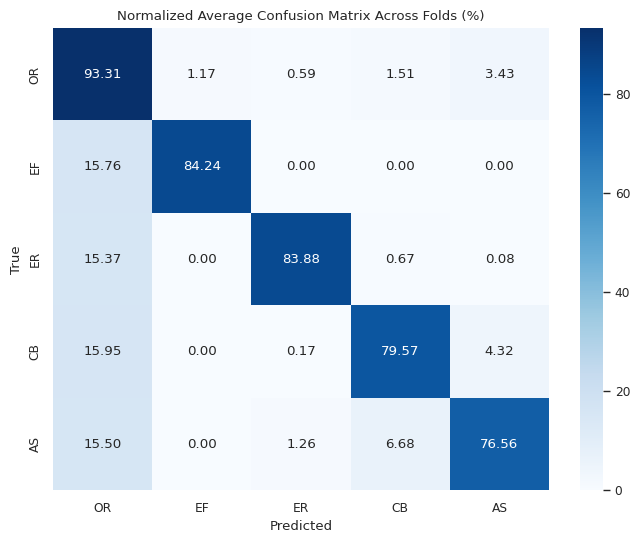

In [ ]:
# @title Confusion Matrix
# Calculate mean accuracy across folds
mean_accuracy = np.mean([result["accuracy"] for result in fold_results])
print(f"Mean Cross-Validated Accuracy: {mean_accuracy:.2f}")

# Aggregate and average confusion matrices, precision, and recall across folds
mean_conf_matrix = np.mean([result["confusion_matrix"] for result in fold_results], axis=0)

# Normalize the confusion matrix by row (i.e., by the true label) and convert to percentages
mean_conf_matrix_normalized = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True) * 100

# Plot averaged normalized confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(mean_conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=MOVEMENT_TYPES, yticklabels=MOVEMENT_TYPES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Average Confusion Matrix Across Folds (%)')
plt.show()
